In [24]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [5]:
# Load the JSON file by line
file_path = '/Users/kevhhu/Downloads/yelp_dataset/yelp_academic_dataset_business.json'
data = []
with open(file_path, 'r') as file:
    for line in file:
        data.append(json.loads(line))

business_df = pd.DataFrame(data)

# Load the Yelp data reviews
review_file_path = '/Users/kevhhu/Downloads/yelp_dataset/yelp_academic_dataset_review.json'
with open(review_file_path, 'r') as file:
    review_data = [json.loads(line) for line in file]
review_df = pd.DataFrame(review_data)

In [7]:
print(business_df['city'].unique())
print(business_df['categories'].head(10))

['Santa Barbara' 'Affton' 'Tucson' ... 'Wales' 'UPPER MORELAND'
 'Apollo beach']
0    Doctors, Traditional Chinese Medicine, Naturop...
1    Shipping Centers, Local Services, Notaries, Ma...
2    Department Stores, Shopping, Fashion, Home & G...
3    Restaurants, Food, Bubble Tea, Coffee & Tea, B...
4                            Brewpubs, Breweries, Food
5    Burgers, Fast Food, Sandwiches, Food, Ice Crea...
6    Sporting Goods, Fashion, Shoe Stores, Shopping...
7                  Synagogues, Religious Organizations
8    Pubs, Restaurants, Italian, Bars, American (Tr...
9    Ice Cream & Frozen Yogurt, Fast Food, Burgers,...
Name: categories, dtype: object


In [15]:
# Normalize city names 
business_df['city'] = business_df['city'].str.strip().str.lower()
business_df['categories'] = business_df['categories'].str.strip().str.lower()

# Filter businesses in Santa Barbara that we do not end up using
santa_barbara_businesses = business_df[business_df['city'] == 'santa barbara']

# Inspect categories sample
print(santa_barbara_businesses['categories'].head(20))

0      doctors, traditional chinese medicine, naturop...
26     women's clothing, accessories, children's clot...
85     food, restaurants, salad, coffee & tea, breakf...
91                        towing, automotive, body shops
120    parenting classes, maternity wear, fashion, ed...
141    live/raw food, restaurants, seafood, beer bar,...
170                                beauty & spas, tattoo
219    motorcycle rental, tours, hiking, mountain bik...
227    professional services, officiants, event plann...
431                                   pizza, restaurants
543           shopping, home & garden, home decor, props
547    health & medical, beauty & spas, skin care, ac...
600    shopping, women's clothing, jewelry, fashion, ...
615    recreation centers, arts & entertainment, virt...
665         masonry/concrete, contractors, home services
691                coffee & tea, coffee roasteries, food
813    fitness & instruction, swimming pools, active ...
847                            

In [17]:
# Filter for pizza places in Santa Barbara based on category keywords
pizza_keywords = ["pizza", "italian", "pizzeria"]

def contains_pizza_keywords(categories):
    if categories is None:
        return False
    return any(keyword in categories for keyword in pizza_keywords)

pizza_businesses_sb = santa_barbara_businesses[
    santa_barbara_businesses['categories'].apply(contains_pizza_keywords)
]

pizza_businesses_sb = pizza_businesses_sb[['business_id', 'name', 'address', 'city', 'state', 'categories', 'stars', 'review_count']]
print("Filtered pizza businesses in Santa Barbara:")
print(pizza_businesses_sb)


Filtered pizza businesses in Santa Barbara:
                   business_id                        name  \
431     ifjluUv4VASwmFqEp8cWlQ               Marty's Pizza   
1451    JWFpjvCc_nkNDVtMPx1ZGg                     Bogo SB   
3804    j-lxie7nEh3UeUTpiqekkQ                Presto Pasta   
4824    HQ-C47_Xi5it1KzwEc0u0A                  Barbarians   
6762    PPcz-0UtIJ8O7xDT551y2g     Intermezzo By Wine Cask   
...                        ...                         ...   
147785  Qkg16mN-8QR66gjzg6gMyw  Convivo Restaurant and Bar   
147947  T_TX4Lx03Juo4pHF5cMYuA    Ca'Dario Pizzeria Veloce   
149075  Qsoq2TGOe59LZy7z6KbQjA              Domino's Pizza   
149317  HrnSaz2f1WUEoAQQ6iD6gw              Lemon Tree Inn   
150290  uriD7RFuHhLJeDdKaf0nFA                  Pizza Guru   

                          address           city state  \
431            2733 De La Vina St  santa barbara    CA   
1451                1114 State St  santa barbara    CA   
3804           827 E Montecito St  sa

In [20]:
# Merge review data with filtered pizza businesses
merged_df_sb = pd.merge(review_df, pizza_businesses_sb, on='business_id', how='inner')

# Check the columns in the merged DataFrame
print("Columns in merged_df_sb:", merged_df_sb.columns)

def check_payment_mentions(text):
    keywords = [
        "online payment", "pay on delivery", "pay on pickup", "pay in store", "prepaid", 
        "cash on delivery", "credit card payment", "mobile payment", "pay with card", 
        "pay with cash", "contactless payment"
    ]
    return any(keyword in text.lower() for keyword in keywords)

merged_df_sb['payment_mention'] = merged_df_sb['text'].apply(check_payment_mentions)

payment_reviews_sb = merged_df_sb[merged_df_sb['payment_mention']]

print("Sample of payment-related reviews:")
print(payment_reviews_sb[['text', 'stars_x']].head())

Columns in merged_df_sb: Index(['review_id', 'user_id', 'business_id', 'stars_x', 'useful', 'funny',
       'cool', 'text', 'date', 'name', 'address', 'city', 'state',
       'categories', 'stars_y', 'review_count'],
      dtype='object')
Sample of payment-related reviews:
                                                    text  stars_x
11618  We were having a hard time finding a place to ...      5.0
19634  Unprofessional. Fraud.\nI used to go here beca...      1.0
19642  ALL customers BEWARE!! Santa Barbara wine spa ...      1.0


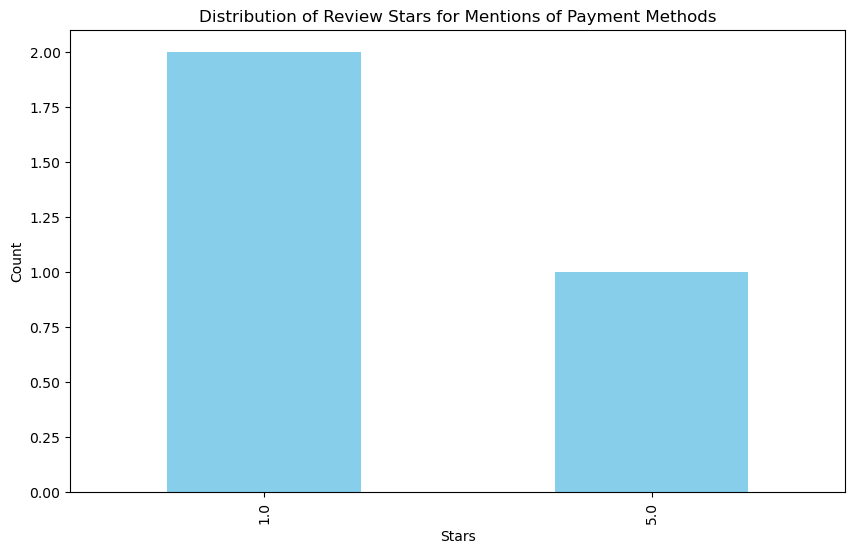

In [25]:
# Plot the distribution of stars for reviews mentioning payment
plt.figure(figsize=(10, 6))
payment_reviews_sb['stars_x'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Review Stars for Mentions of Payment Methods')
plt.xlabel('Stars')
plt.ylabel('Count')
plt.show()

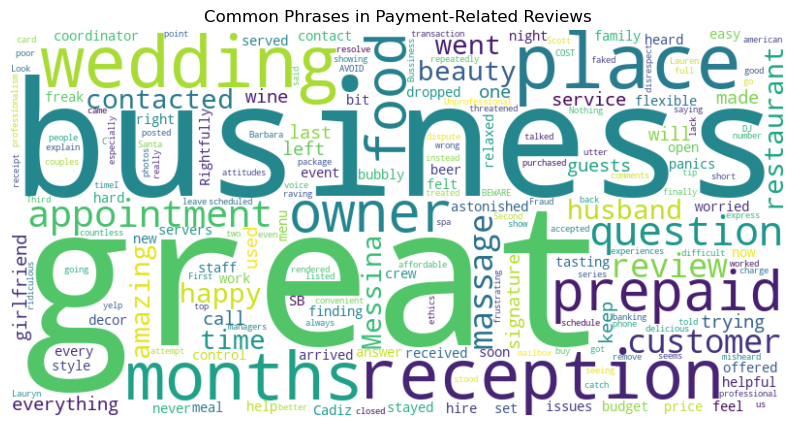

In [26]:
# Generate a word cloud of payment-related reviews
payment_text_sb = ' '.join(payment_reviews_sb['text'].tolist())
wordcloud_sb = WordCloud(width=800, height=400, background_color='white').generate(payment_text_sb)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_sb, interpolation='bilinear')
plt.axis('off')
plt.title('Common Phrases in Payment-Related Reviews')
plt.show()

## Review
Thus far these have not shown much results that support any kind of changes for Pizzeria Mamma Mia

In [27]:
import re
# Define positive and negative service keywords
positive_keywords = [
    "fast service", "quick service", "prompt service", "efficient service", 
    "fast delivery", "quick delivery", "prompt delivery", "quick turnaround",
    "timely service", "on time", "quick", "speedy", "rapid", "efficient",
    "swift", "hasty", "prompt"
]
negative_keywords = [
    "slow service", "poor service", "bad service", "delayed service",
    "slow delivery", "poor delivery", "bad delivery", "long wait", 
    "waited too long", "late", "unresponsive", "slow", "sluggish",
    "tardy", "delayed", "leisurely", "unhurried"
]

# Combine keywords into a single regex pattern 
positive_pattern = re.compile('|'.join(positive_keywords), re.IGNORECASE)
negative_pattern = re.compile('|'.join(negative_keywords), re.IGNORECASE)

# ategorize reviews based on keywords
def categorize_review(text):
    if re.search(positive_pattern, text):
        return 'positive'
    elif re.search(negative_pattern, text):
        return 'negative'
    else:
        return 'neutral'
        
review_df['service_mention'] = review_df['text'].apply(categorize_review)


service_mention
negative    3.259979
positive    4.000374
Name: stars, dtype: float64


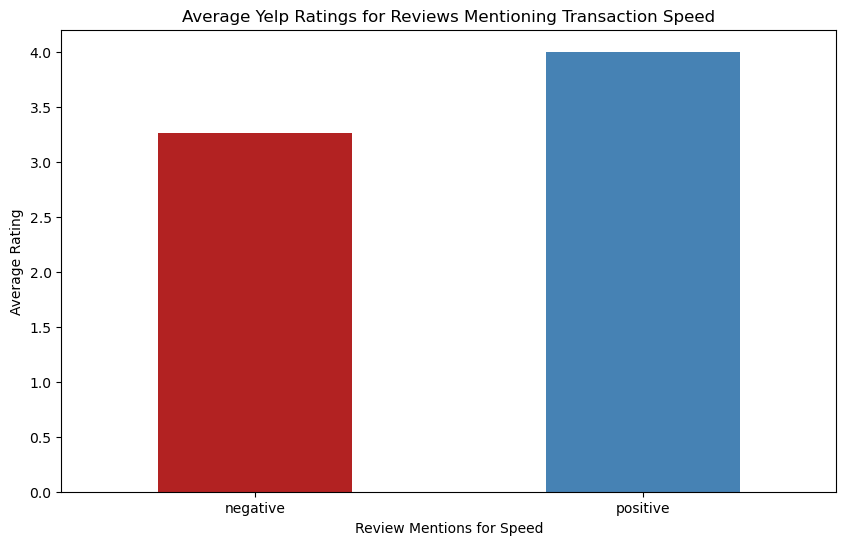

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
average_ratings.plot(kind='bar', color=['firebrick', 'steelblue'])
plt.title('Average Yelp Ratings for Reviews Mentioning Transaction Speed')
plt.xlabel('Review Mentions for Speed')
plt.ylabel('Average Rating')
plt.xticks(rotation=0)
plt.show()


In [30]:
# Load checkin data
checkin_file_path = '/Users/kevhhu/Downloads/yelp_dataset/yelp_academic_dataset_checkin.json'
with open(checkin_file_path, 'r') as file:
    checkin_data = [json.loads(line) for line in file]
checkin_df = pd.DataFrame(checkin_data)

# Load tip data
tip_file_path = '/Users/kevhhu/Downloads/yelp_dataset/yelp_academic_dataset_tip.json'
with open(tip_file_path, 'r') as file:
    tip_data = [json.loads(line) for line in file]
tip_df = pd.DataFrame(tip_data)

# Load user data
user_file_path = '/Users/kevhhu/Downloads/yelp_dataset/yelp_academic_dataset_user.json'
with open(user_file_path, 'r') as file:
    user_data = [json.loads(line) for line in file]
user_df = pd.DataFrame(user_data)


service_mention
negative    1.0
positive    1.0
Name: checkin_count, dtype: float64


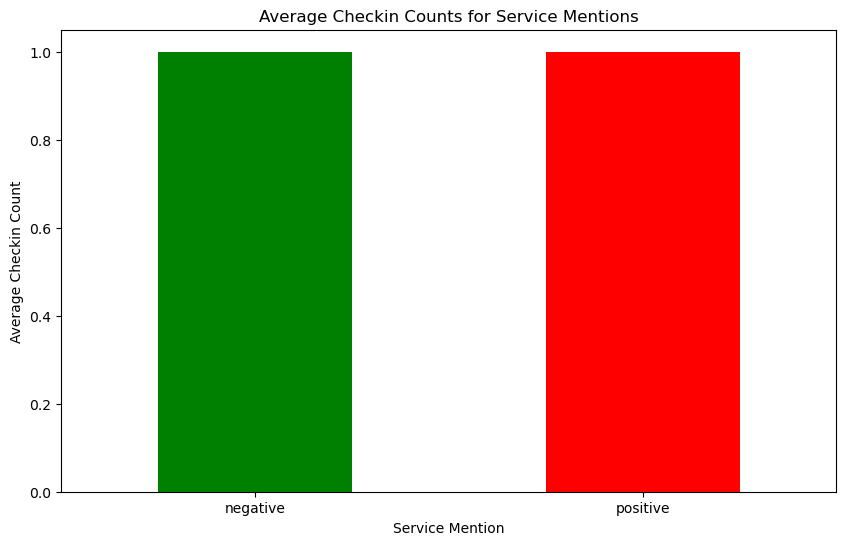

In [31]:
# Merge checkin data with business data
merged_checkin = pd.merge(checkin_df, business_df, on='business_id', how='inner')

# Analyze checkin patterns
checkin_summary = merged_checkin.groupby('business_id')['date'].count().reset_index()
checkin_summary.columns = ['business_id', 'checkin_count']

# Merge checkin summary with service reviews
merged_service_checkin = pd.merge(service_reviews, checkin_summary, on='business_id', how='inner')

# Compare average checkin counts for positive and negative service mentions
average_checkins = merged_service_checkin.groupby('service_mention')['checkin_count'].mean()
print(average_checkins)

# Plot the comparison
plt.figure(figsize=(10, 6))
average_checkins.plot(kind='bar', color=['green', 'red'])
plt.title('Average Checkin Counts for Service Mentions')
plt.xlabel('Service Mention')
plt.ylabel('Average Checkin Count')
plt.xticks(rotation=0)
plt.show()


## Review
The corss referernce didn't provide any additional helpful results and could definitely be explored further however, I lack space in the report